# 项目：探索TMDB电影数据集调查数据集

## 加载工具

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option("display.max_columns",0)


## 整理数据

In [2]:
# 加载数据集
def load_data():
    df = pd.read_csv("tmdb-movies.csv")
    return df
if __name__ == '__main__':
    df = load_data()

In [3]:
# 查看数据集的记录和属性的数量。分别是10866条和21个属性。
df.shape

(10866, 21)

In [4]:
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


>相关属性的介绍。暂时没有找到官方解释，手动翻译以下。
1. id 编号 
2. imdb_id IMDB编号 
3. popularity 在 Movie Database 上的相对页面查看次数
4. budget 预算，单位是美元
5. revenue 收入，单位是美元
6. original_title 电影名称
7. cast 主要演员，使用"|"进行分隔
8. homepage 电影网站
9. director 导演，使用"|"进行分隔
10. tagline 宣传口号
11. keywords 关键字
12. overview 简介
13. runtime 电影时长，单位是min
14. genres 电影类型，使用"|"进行分隔
15. production_companies 出品公司，使用"|"进行分隔
16. release_date 发行日期
17. vote_count 投票的数量
18. vote_average 投票的平均分
19. release_year 发行年份
20. budget_adj 调整后预算，调整inflation。数量级是10^8(亿元)，货币单位是美元
21. revenue_adj 调整后收入，调整inflation。数量是10^8(亿元)，货币单位是美元
参考网站：https://zhuanlan.zhihu.com/p/48415482

In [5]:
#主要目的是查看每个属性的数据类型，以及数据类型是否与属性相一致。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

1. 其次是看看每个属性是否存在null记录。
2. 从输出结果来看，存在null的记录。需要在后续进行处理。
3. released_date应该是datetime类型，release_year应该是datetime类型。

In [6]:
# 查看是否存在空值
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

+ 根据实际需要，处理存在null的记录。
+ 首先应该找到所有的属性都是null的记录，直接去除。
+ 如果需要分析主演与电影的关系，那么需要将cast字段缺失的记录去掉。
+ 电影是否有主页，与电影的评分等情况关系较小，没有主页的记录占总记录的比例超过50%，因此不能简单的进行去除空值记录。
+ 如果需要分析出品公司与电影的关系，需要将production_companies字段缺失的记录去掉。
+ 如果需要分析电影类型与电影评分的关系，需要将genres缺失的记录去掉。


In [7]:
# 查看是否存在重复的记录
df.duplicated().sum()

1

+ 对于重复记录，只有一条，删除处理。

+ 根据需要选择无关字段或者属性，并删除处理。
+ 综上，其中“overview”,"keywords","tagline"属于无关字段。
+ 另外，“budget”,"revenue"字段与“budget_adj”,"revenue_adj"选择一组即可，优先选择后者，因为不受物价水平影响。
+ “release_date”与“release_year”应该选择一个即可，如果没有必要详细到发型的日期，那么选择后者即可。
+ "vote_count"字段，与电影评分或者电影本身关系不大，只与投票人数有关或者总票数有关。
+ "popularity"字段，暂时保留，不确定这个字段的意义。

In [8]:
df.nunique()

id                      10865
imdb_id                 10855
popularity              10814
budget                    557
revenue                  4702
original_title          10571
cast                    10719
homepage                 2896
director                 5067
tagline                  7997
keywords                 8804
overview                10847
runtime                   247
genres                   2039
production_companies     7445
release_date             5909
vote_count               1289
vote_average               72
release_year               56
budget_adj               2614
revenue_adj              4840
dtype: int64

In [9]:
# 查看数值类型的字段的描述统计特征，判断是否存在异常值，
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


+ “id”字段，最小值是5，需要研究一下。
+ “popularity”字段，最大值是 32,而均值是 0.64，并且这个字段是否有存在的意义，也需要研究一下。
+ “budget”, "revenue" 字段中最小值是0，这个显然不合理，包括"budget_adj"和“revenue_adj”
+ "runtime"字段，最小值为0，这个显然不合理。那么电影时长的合理范围应该是多少？这个可能需要主观选择：至少60min。

### 疑问？
1. 如何找到彼此重复的记录。

## 数据清理

In [10]:
# 创建原数据集的副本，保留原数据集，做好备份。
df_copy = df.copy()
df_copy.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


### 删除重复的记录

In [11]:
df_copy.drop_duplicates(inplace = True)
# 查看去重的结果。
df_copy.duplicated().sum()

0

### 处理不需要的列，以及列名
- 参考 https://blog.csdn.net/moyue1002/article/details/80332186
- 其中提出了，id字段可以作为无用字段进行删除处理。

In [12]:
df_copy.columns

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [13]:
df_copy.drop(["overview","tagline","keywords","homepage","vote_count","release_date","revenue","budget","id"],axis =1 ,inplace = True)

In [14]:
df_copy.columns

Index(['imdb_id', 'popularity', 'original_title', 'cast', 'director',
       'runtime', 'genres', 'production_companies', 'vote_average',
       'release_year', 'budget_adj', 'revenue_adj'],
      dtype='object')

In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 12 columns):
imdb_id                 10855 non-null object
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              10865 non-null float64
revenue_adj             10865 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


In [16]:
#因为删除了重复的记录，因此index不连续，需要进行reset_index操作。
df_copy.reset_index(drop=True,inplace = True)

In [17]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10865 entries, 0 to 10864
Data columns (total 12 columns):
imdb_id                 10855 non-null object
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              10865 non-null float64
revenue_adj             10865 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1018.7+ KB


### 处理空值

In [18]:
df_copy.isnull().sum()

imdb_id                   10
popularity                 0
original_title             0
cast                      76
director                  44
runtime                    0
genres                    23
production_companies    1030
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [19]:
df_copy.dropna(axis = 0,subset=['imdb_id','cast','director','genres'],inplace = True)

In [20]:
df_copy.isnull().sum()

imdb_id                   0
popularity                0
original_title            0
cast                      0
director                  0
runtime                   0
genres                    0
production_companies    956
vote_average              0
release_year              0
budget_adj                0
revenue_adj               0
dtype: int64

### 处理数据类型

In [21]:
df_copy.head(1)

,imdb_id,popularity,original_title,cast,director,runtime,genres,production_companies,vote_average,release_year,budget_adj,revenue_adj
0,tt0369610,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6.5,2015,1.379999e+08,1.392446e+09


In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10726 entries, 0 to 10864
Data columns (total 12 columns):
imdb_id                 10726 non-null object
popularity              10726 non-null float64
original_title          10726 non-null object
cast                    10726 non-null object
director                10726 non-null object
runtime                 10726 non-null int64
genres                  10726 non-null object
production_companies    9770 non-null object
vote_average            10726 non-null float64
release_year            10726 non-null int64
budget_adj              10726 non-null float64
revenue_adj             10726 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


In [23]:
df_copy['runtime']= df_copy['runtime'].astype(float)

In [24]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10726 entries, 0 to 10864
Data columns (total 12 columns):
imdb_id                 10726 non-null object
popularity              10726 non-null float64
original_title          10726 non-null object
cast                    10726 non-null object
director                10726 non-null object
runtime                 10726 non-null float64
genres                  10726 non-null object
production_companies    9770 non-null object
vote_average            10726 non-null float64
release_year            10726 non-null int64
budget_adj              10726 non-null float64
revenue_adj             10726 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.1+ MB


### 处理异常值

In [25]:
df_copy.describe()

,popularity,runtime,vote_average,release_year,budget_adj,revenue_adj
count,10726.000000,10726.000000,10726.000000,10726.000000,1.072600e+04,1.072600e+04
mean,0.652779,102.493660,5.964218,2001.256013,1.777358e+07,5.203047e+07
std,1.004995,30.473355,0.930185,12.821962,3.447220e+07,1.454547e+08
min,0.000188,0.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,0.210766,90.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,0.387136,99.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,0.721518,112.000000,6.600000,2011.000000,2.112691e+07,3.475061e+07
max,32.985763,900.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


> #### 需要处理异常值的列，包括‘runtime’,'budget_adj','revenue_adj'
- 'runtime'表示电影的时长，因此最小值如果是0，显然不合理，考虑填充处理，使用second quantile的值是90
- ‘budget_adj’和‘revenue_adj’表示金额，因此如果最小值是0，显然不合理，需要使用value_counts查看数值分布，再决定是填充或者删除

In [26]:
df_copy['runtime'].value_counts()

90.0     543
95.0     358
100.0    330
93.0     327
97.0     305
        ... 
33.0       1
34.0       1
352.0      1
210.0      1
193.0      1
Name: runtime, Length: 243, dtype: int64

In [28]:
df_copy['budget_adj'].value_counts()

0.000000e+00    5574
2.103337e+07      17
1.016400e+07      17
2.000000e+07      16
4.605455e+06      15
                ... 
2.098438e+07       1
6.118561e+07       1
4.074107e+07       1
1.211748e+05       1
3.969055e+07       1
Name: budget_adj, Length: 2602, dtype: int64

In [30]:
df_copy['revenue_adj'].value_counts()

0.000000e+00    5883
2.910640e+07       2
8.990674e+07       2
1.438914e+07       2
1.000000e+06       2
                ... 
1.013560e+08       1
7.036068e+07       1
2.714497e+07       1
7.694895e+07       1
1.006471e+07       1
Name: revenue_adj, Length: 4835, dtype: int64

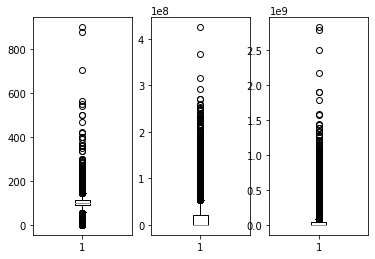

In [37]:
plt.subplot(1,3,1)
plt.boxplot(df_copy['runtime'])
plt.subplot(1,3,2)
plt.boxplot(df_copy['budget_adj'])
plt.subplot(1,3,3)
plt.boxplot(df_copy['revenue_adj'])
plt.show()

In [44]:
df_copy.query("runtime > 400")

,imdb_id,popularity,original_title,cast,director,runtime,genres,production_companies,vote_average,release_year,budget_adj,revenue_adj
1865,tt1533395,0.102223,Life,David Attenborough|Oprah Winfrey,Martha Holmes|Simon Blakeney|Stephen Lyle,500.0,Documentary,British Broadcasting Corporation (BBC),7.0,2009,0.0,0.000000e+00
2169,tt1453159,0.082894,The Pillars of the Earth,Ian McShane|Matthew Macfadyen|Eddie Redmayne|H...,Sergio Mimica-Gezzan,421.0,Drama|History|Romance,Scott Free Productions|Tandem Communications|T...,7.3,2010,0.0,0.000000e+00
2213,tt0374463,0.757082,The Pacific,James Badge Dale|Joseph Mazzello|Jon Seda|Asht...,Jeremy Podeswa|Tim Van Patten|David Nutter|Gra...,540.0,War|Drama|Action|Adventure|History,Playtone|HBO|DreamWorks Television,7.8,2010,120000000.0,0.000000e+00
2721,tt0185906,0.537593,Band of Brothers,Damian Lewis|Ron Livingston|Frank John Hughes|...,Phil Alden Robinson|Richard Loncraine|Mikael S...,705.0,Action|Drama|War,HBO,8.0,2001,0.0,1.539360e+08
3140,tt0995832,0.336308,Generation Kill,Alexander SkarsgÃ¥rd|James Ransone|Lee Tergese...,Susanna White|Simon Cellan Jones,470.0,Drama|War|History,Company Pictures,6.6,2008,0.0,0.000000e+00
3355,tt0472027,0.136540,John Adams,Paul Giamatti|Laura Linney|Stephen Dillane|Tom...,Tom Hooper,501.0,History|Drama,NaN,6.6,2008,0.0,0.000000e+00
3893,tt2044056,0.006925,The Story of Film: An Odyssey,Mark Cousins|Jean-Michel Frodon|Cari Beauchamp...,Mark Cousins,900.0,Documentary,NaN,9.2,2011,0.0,0.000000e+00
4040,tt0289830,0.469332,Taken,Dakota Fanning|Matt Frewer|Eric Close|Emily Be...,Breck Eisner|FÃ©lix EnrÃ­quez AlcalÃ¡|John Faw...,877.0,Science Fiction,DreamWorks,6.8,2002,0.0,0.000000e+00
6175,tt0090015,0.147489,Shoah,Simon Srebnik|Michael Podchlebnik|Motke Zaidl,Claude Lanzmann,566.0,Documentary,British Broadcasting Corporation (BBC)|MinistÃ...,8.3,1985,0.0,0.000000e+00
6893,tt0795176,0.137913,Planet Earth,David Attenborough,Alastair Fothergill,550.0,Documentary,NaN,7.6,2006,0.0,0.000000e+00


### 需要解决的问题：
- 为了分析主演与电影评分的关系，需要将主演从‘cast’字段分离出来，需要创建多个新记录，每条记录中主演只有一个。
- 同理，导演与电影评分的关系，出品公司与电影评分的关系，或者统计票房多少。都需要对相应字段的中‘｜’进行分配，并创建新的记录。